In [3]:
import torch
import numpy as np
from torch import nn
import random
import torch.nn.functional as F
import collections
from torch.optim.lr_scheduler import StepLR
# from CommunicationP3DX import CommunicationP3DX
# from Agent import AgentClass
# from std_srvs.srv import Empty
# import rospy
import time
import shelve
import os
from datetime import datetime
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def get_complete_hist_from_shelve(workspace_folder_path, agg_method, n_sectors):
    return shelve.open(workspace_folder_path+'/wsh_{metodo}{n_setores}completo.out'.format(
        metodo = agg_method,n_setores = n_sectors
    ))['hist_dict']

def get_rewards_df(hist_dict,method):
    rewards = []
    episodes = []
    for key in hist_dict['rewards'].keys():
        episodes.append(key)
        rewards.append(hist_dict['rewards_eval'][key][0])
    return pd.DataFrame({'Episodes':episodes, 'Rewards'+method:rewards})

def get_distances_df(hist_dict, method):
    distances = []
    episodes = []
    for key in hist_dict['rewards'].keys():
        episodes.append(key)
        distances.append(hist_dict['rewards_eval'][key][1])
    return pd.DataFrame({'Episodes':episodes, 'Distances'+method:distances})

# 0 for crash, 1 for goal 2 for time
def get_success_df(hist_dict,method):
    success = []
    episodes = []
    for key in hist_dict['epresult'].keys():
        episodes.append(key)
        success.append(hist_dict['epresult'][key][1])
    df = pd.DataFrame({'Episodes':episodes, 'Success'+method:success})
    df['Success'+method] = np.where(df['Success'+method]==1,1,0)
    return df

def get_collision_df(hist_dict,method):
    collision = []
    episodes = []
    for key in hist_dict['epresult'].keys():
        episodes.append(key)
        collision.append(int(np.where(hist_dict['epresult'][key][1]==0,1,0)))
    df = pd.DataFrame({'Episodes':episodes, 'Collision'+method:collision})
    return df


In [5]:
# get hists by method
workspace_folder_path = 'C:/Users/alexa/Desktop/sia_DRL_2023/25k/'
#  '/media/xnd/7A309A87309A49D1/sia_23/25k/'

training_list = [
    ['mean','4']
    ,['mean','5']
    ,['mean','6']
    ,['mean','10']
    ,['min','4']
    ,['min','5']
    ,['min','6']
    ,['min','10']
    ]

results_dfs = {}
for agg_method, n_sectors in training_list:
    print('Processing: {agg_method}-{n_sectors}'.format(agg_method=agg_method,  n_sectors=n_sectors))
    hist = get_complete_hist_from_shelve(workspace_folder_path, agg_method, n_sectors)

    results_dfs[agg_method+'_'+n_sectors] = {
        'rewards_df':get_rewards_df(hist, method=agg_method),
        'distances_df':get_distances_df(hist, method=agg_method),
        'success_df':get_success_df(hist, method=agg_method),
        'collisions_df':get_collision_df(hist, method=agg_method)

    }
    
    del hist

import pickle
with open('mean_min_25k_results_dfs.pickle', 'wb') as handle:
    pickle.dump(results_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

Processing: mean-4
Processing: mean-5
Processing: mean-6
Processing: mean-10
Processing: min-4
Processing: min-5
Processing: min-6
Processing: min-10


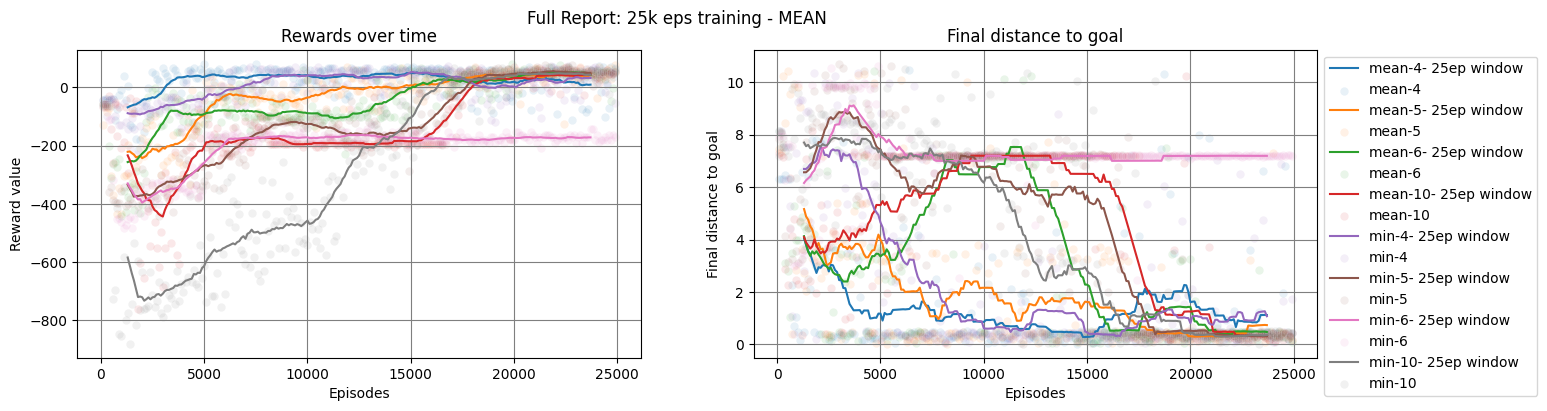

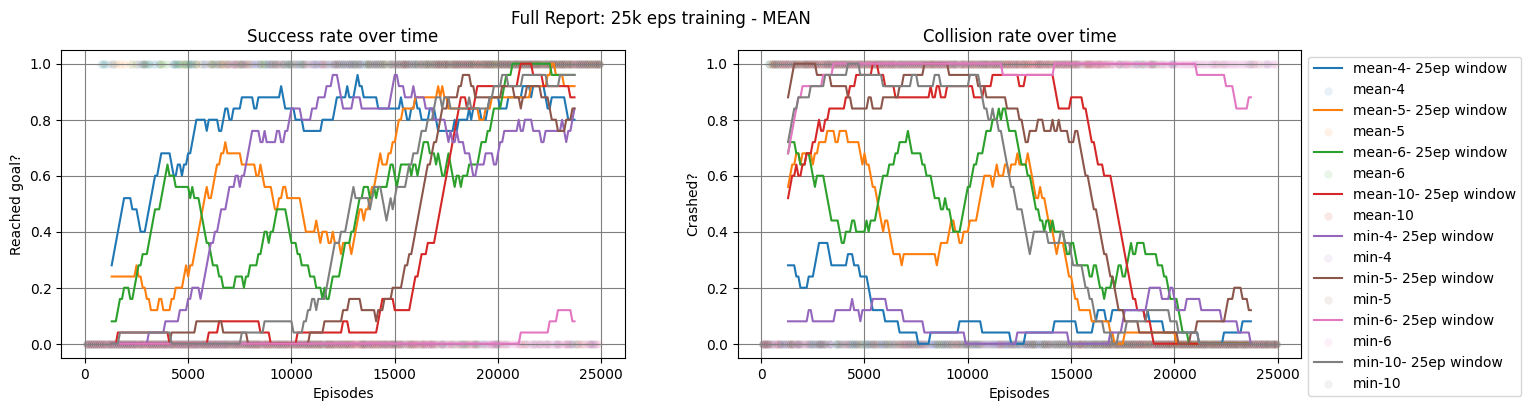

In [6]:
# plot aggt report - rewards and final distance

rolling_window_size = 25
center_window = True
fig = plt.figure(figsize = (16,4), dpi = 100)
fig.suptitle('Full Report: 25k eps training - MEAN')

for agg_method, n_sectors in training_list:    

    plt.subplot(121);
    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df'].rolling(rolling_window_size, center=center_window).mean()
                 ,x = 'Episodes', y='Rewards'+agg_method
                #  , label=agg_method+'- '+str(rolling_window_size)+'ep mean'
                );
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df']
                    ,x = 'Episodes', y='Rewards'+agg_method
                    # , label=agg_method
                    , alpha = 0.1);

    
    plt.title('Rewards over time');
    plt.ylabel('Reward value')
    plt.grid(True, c='tab:gray')

    plt.subplot(122);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['distances_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Distances'+agg_method
                 , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )+'- '\
                    +str(rolling_window_size)+'ep window'
                    );
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['distances_df']
                    ,x = 'Episodes', y='Distances'+agg_method
                    , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )
                    , alpha = 0.1);

    plt.title('Final distance to goal');
    plt.ylabel('Final distance to goal')
    plt.grid(True, c='tab:gray')

plt.legend(loc = 'upper left', bbox_to_anchor =(1,1))   
plt.show()

# plot aggt report - collision and success
fig = plt.figure(figsize = (16,4), dpi = 100)
fig.suptitle('Full Report: 25k eps training - MEAN')

for agg_method, n_sectors in training_list:    

    plt.subplot(121);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['success_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Success'+agg_method);
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['success_df']
                    ,x = 'Episodes', y='Success'+agg_method
                    , alpha = 0.1);

    
    plt.title('Success rate over time');
    plt.ylabel('Reached goal?')
    plt.grid(True, c='tab:gray')

    plt.subplot(122);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['collisions_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Collision'+agg_method
                 , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )+'- '\
                    +str(rolling_window_size)+'ep window'
                    );

    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['collisions_df']
                    ,x = 'Episodes', y='Collision'+agg_method
                    , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )
                    , alpha = 0.1);

    plt.title('Collision rate over time');
    plt.ylabel('Crashed?')
    plt.grid(True, c='tab:gray')

plt.legend(loc = 'upper left', bbox_to_anchor =(1,1))   
plt.show()

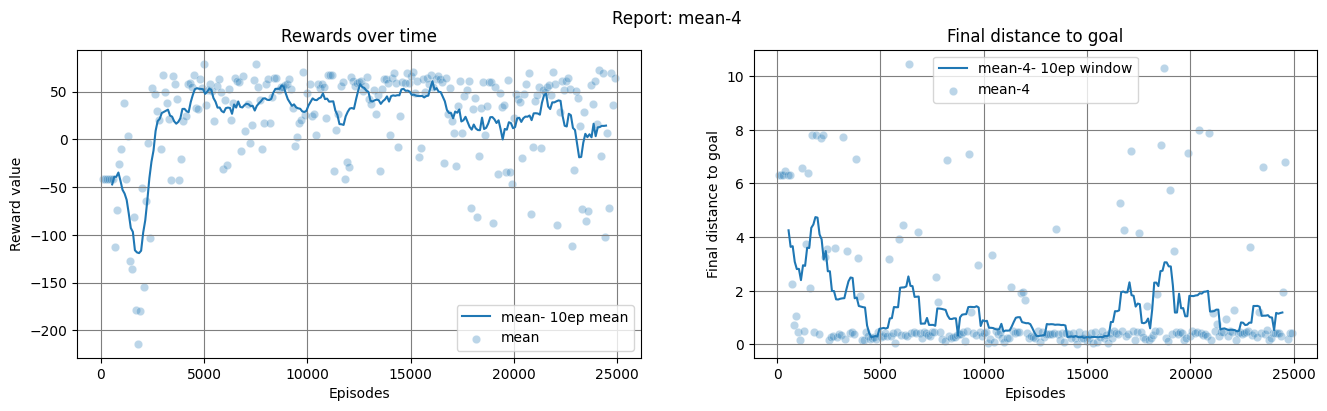

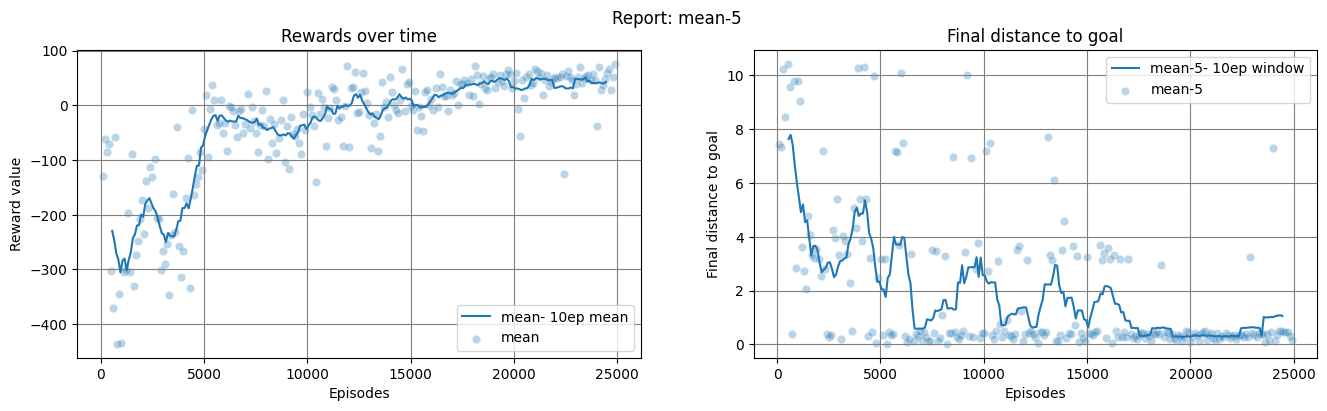

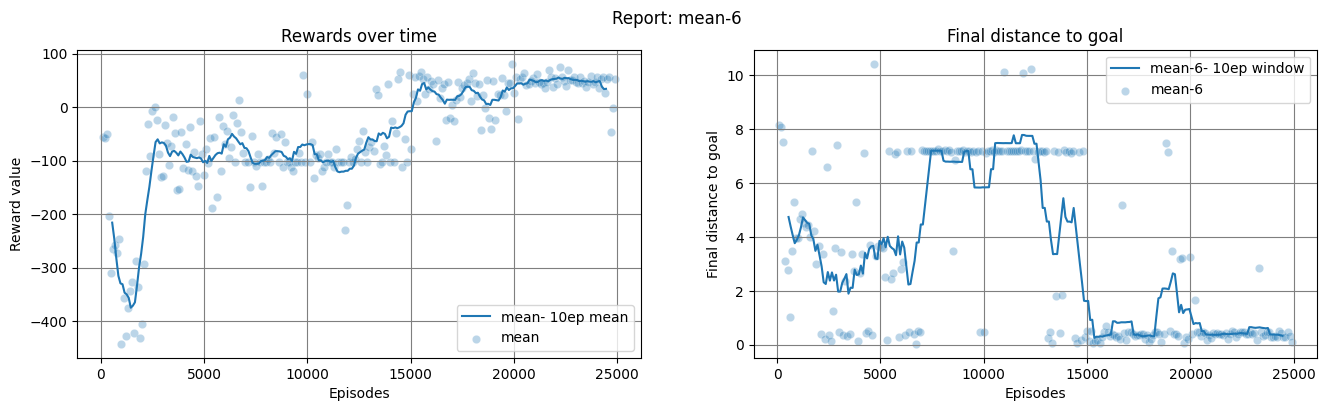

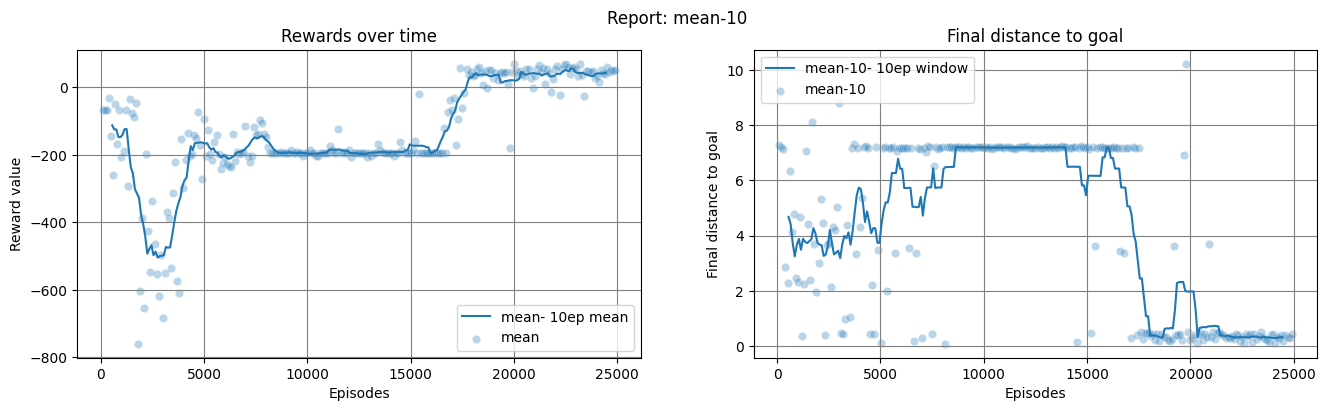

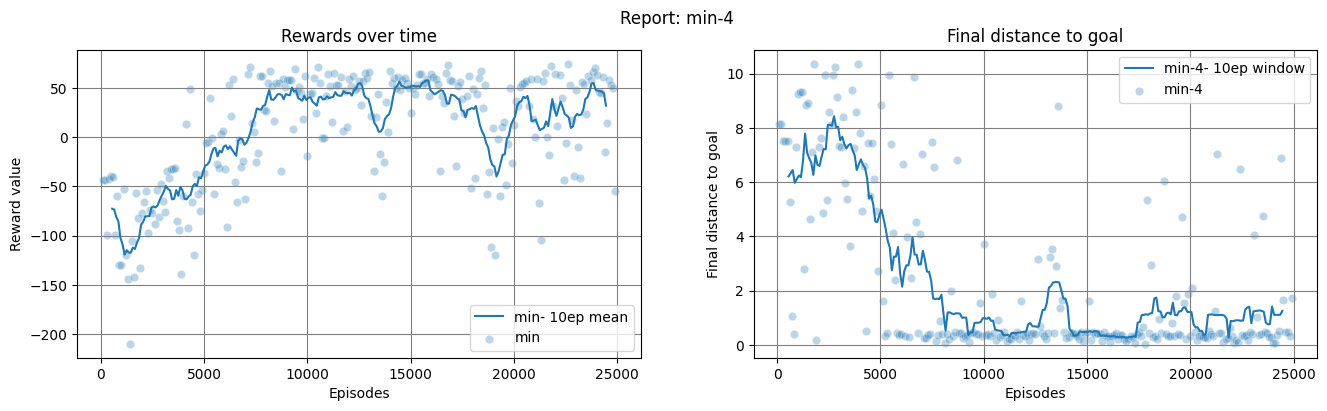

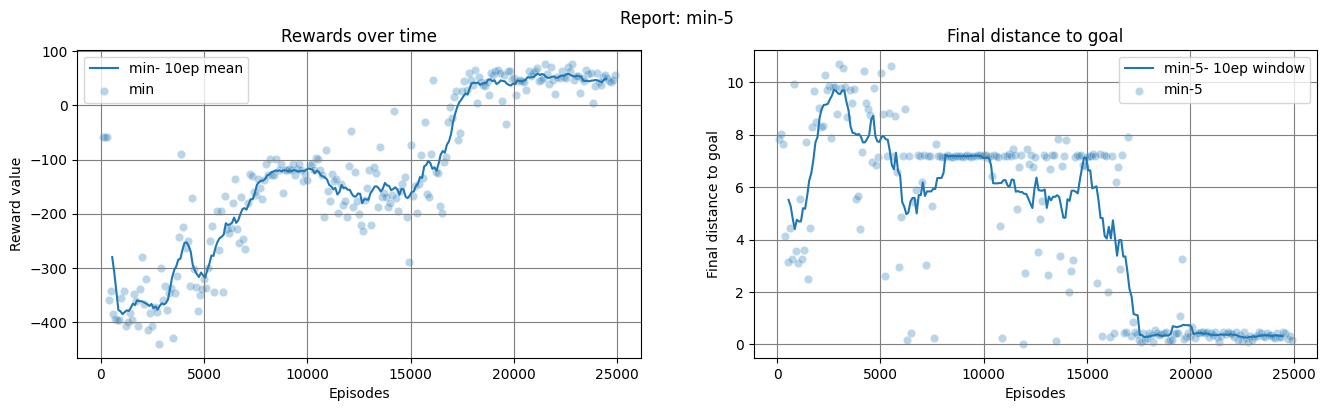

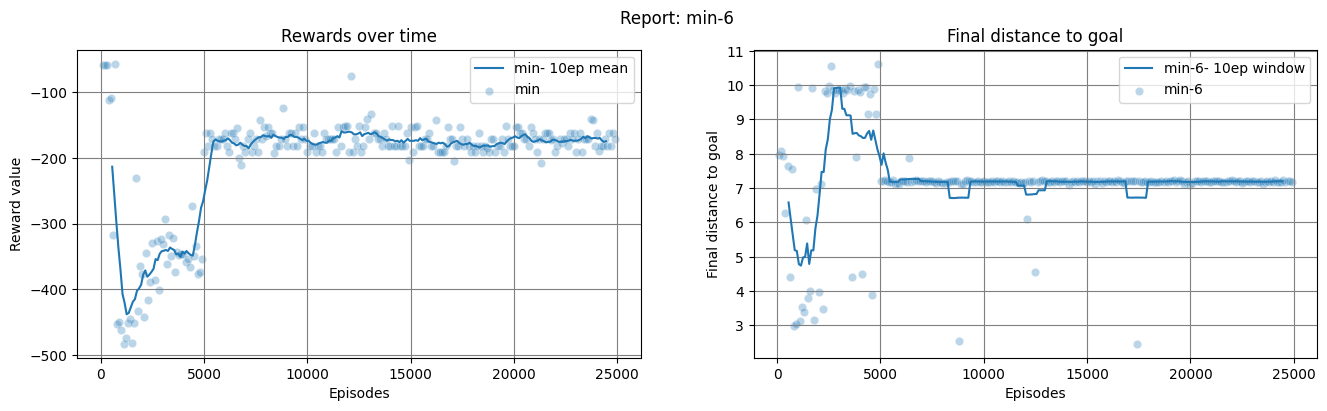

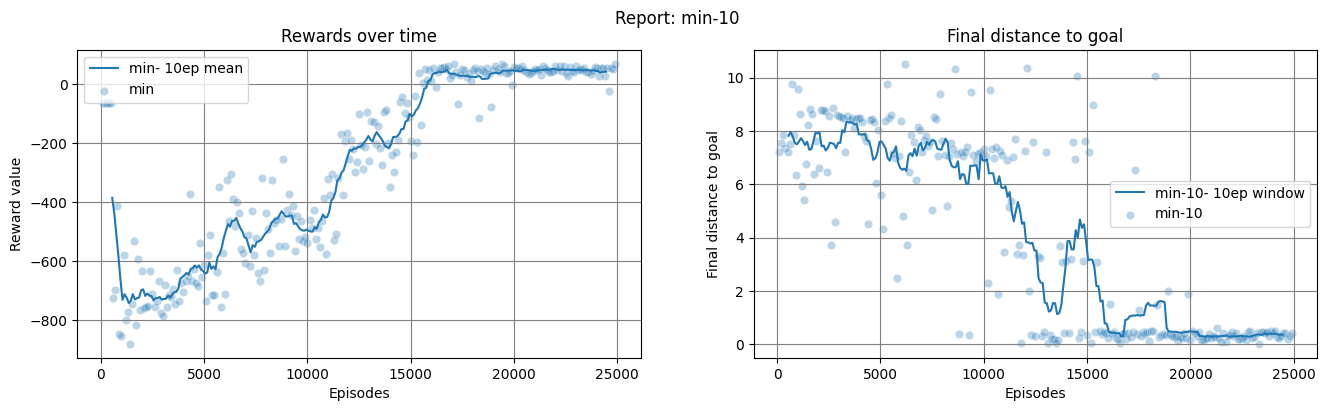

In [7]:
# plot individual report

rolling_window_size = 10

for agg_method, n_sectors in training_list:
    fig = plt.figure(figsize=(16,4), dpi=100)

    plt.subplot(121);
    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df'].rolling(rolling_window_size).mean()
                 ,x = 'Episodes', y='Rewards'+agg_method, label=agg_method+'- '+str(rolling_window_size)+'ep mean');
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df']
                    ,x = 'Episodes', y='Rewards'+agg_method, label=agg_method, alpha = 0.3);

    plt.legend()
    plt.title('Rewards over time');
    plt.ylabel('Reward value')
    plt.grid(True, c='tab:gray')

    plt.subplot(122);
    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['distances_df'].rolling(rolling_window_size).mean()
                 ,x = 'Episodes', y='Distances'+agg_method
                 , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )+'- '\
                    +str(rolling_window_size)+'ep window'
                    );
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['distances_df']
                    ,x = 'Episodes', y='Distances'+agg_method
                    , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )
                    , alpha = 0.3);

    plt.legend()
    plt.title('Final distance to goal');
    plt.ylabel('Final distance to goal')
    plt.grid(True, c='tab:gray')

    fig.suptitle('Report: {method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors ))
    plt.show()

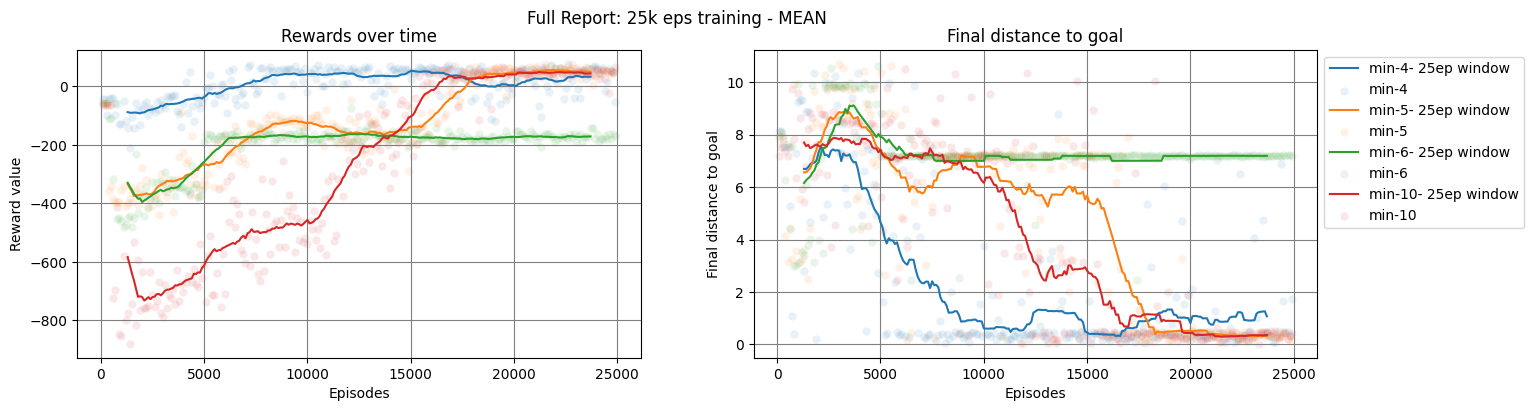

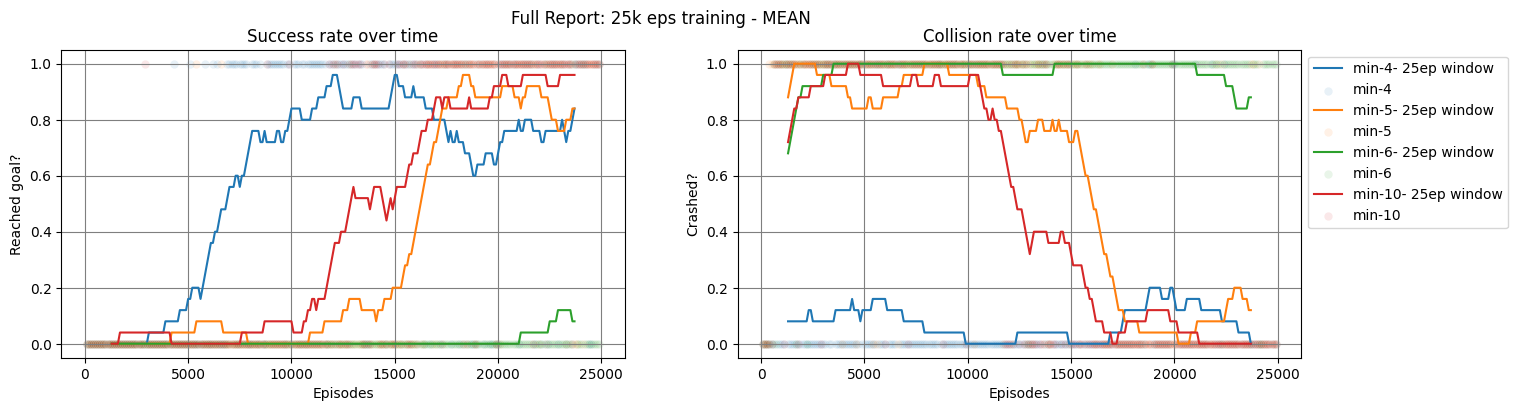

In [10]:
# plot aggt report - rewards and final distance

rolling_window_size = 25
center_window = True
fig = plt.figure(figsize = (16,4), dpi = 100)
fig.suptitle('Full Report: 25k eps training - MEAN')

for agg_method, n_sectors in training_list[4:]:    

    plt.subplot(121);
    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df'].rolling(rolling_window_size, center=center_window).mean()
                 ,x = 'Episodes', y='Rewards'+agg_method
                #  , label=agg_method+'- '+str(rolling_window_size)+'ep mean'
                );
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['rewards_df']
                    ,x = 'Episodes', y='Rewards'+agg_method
                    # , label=agg_method
                    , alpha = 0.1);

    
    plt.title('Rewards over time');
    plt.ylabel('Reward value')
    plt.grid(True, c='tab:gray')

    plt.subplot(122);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['distances_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Distances'+agg_method
                 , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )+'- '\
                    +str(rolling_window_size)+'ep window'
                    );
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['distances_df']
                    ,x = 'Episodes', y='Distances'+agg_method
                    , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )
                    , alpha = 0.1);

    plt.title('Final distance to goal');
    plt.ylabel('Final distance to goal')
    plt.grid(True, c='tab:gray')

plt.legend(loc = 'upper left', bbox_to_anchor =(1,1))   
plt.show()

# plot aggt report - collision and success
fig = plt.figure(figsize = (16,4), dpi = 100)
fig.suptitle('Full Report: 25k eps training - MEAN')

for agg_method, n_sectors in training_list[4:]:    

    plt.subplot(121);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['success_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Success'+agg_method);
    
    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['success_df']
                    ,x = 'Episodes', y='Success'+agg_method
                    , alpha = 0.1);

    
    plt.title('Success rate over time');
    plt.ylabel('Reached goal?')
    plt.grid(True, c='tab:gray')

    plt.subplot(122);

    sns.lineplot(results_dfs[agg_method+'_'+n_sectors]['collisions_df'].rolling(rolling_window_size,center=center_window).mean()
                 ,x = 'Episodes', y='Collision'+agg_method
                 , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )+'- '\
                    +str(rolling_window_size)+'ep window'
                    );

    sns.scatterplot(results_dfs[agg_method+'_'+n_sectors]['collisions_df']
                    ,x = 'Episodes', y='Collision'+agg_method
                    , label='{method}-{n_sectors}'.format(method=agg_method, n_sectors=n_sectors )
                    , alpha = 0.1);

    plt.title('Collision rate over time');
    plt.ylabel('Crashed?')
    plt.grid(True, c='tab:gray')

plt.legend(loc = 'upper left', bbox_to_anchor =(1,1))   
plt.show()